In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#http://iss.moex.com/iss/reference/
#http://iss.moex.com/iss/securitygroups/stock_index/collections
from pytesseract import image_to_string
import requests
import pandas as pd
from multiprocessing.dummy import Pool
from functools import partial
from PIL import Image,ImageEnhance,ImageFilter
from io import BytesIO

class mosex:
    __slots__ = ['base_url','references_dict','return_data_type','error']

    def __init__(self):
        self.base_url = r'http://iss.moex.com/iss/'

        self.references_dict ={'securities_list':{'link':'securities'
                                                 ,'chunk':False},
                               'global_dict':{'link':r'index'
                                               ,'chunk':False}
                                ,'security_spec':{'link':r'securities/{r[security]}'
                                                  ,'chunk':False}
                                ,'security_history':{'link':r'history/engines/{r[engine]}/markets/{r[market]}/securities/{r[security]}'
                                                     ,'chunk':True}
                               ,'index_list':{'link':r'statistics/engines/stock/markets/index/analytics'
                                             , 'chunk':False}
                               }
        self.return_data_type='json'
        self.error=False
        
    def __url_construct(self,reference,params=None):
 
        url='{0}{1}.{2}'.format(self.base_url,self.references_dict[reference]['link'],self.return_data_type)
        if params is not None:
            url=url.format(r=params)
        return url
    
    def __dataframe_template(self,data_arr):
        return pd.DataFrame(data_arr['data'],columns=data_arr['columns']) 
    
    def __dataframes_from_request(self,response):
        res=[]
        json_data=response.json()
        res= {key:self.__dataframe_template(data)
              for key,data in json_data.items()
             }
        return res
    
    def  __request_exeption(self,url,err,params=None) :
        if err is False:
            print ('error quering url {}'.format(url))
            if params:
                print (params)
            self.error=True
            
    def query(self,reference,reference_params=None):

        url=self.__url_construct(reference,params=reference_params)
        response=requests.get(url)

        self.__request_exeption(url,response.ok)     
        return self.__dataframes_from_request(response)
    
    def __security_hist_worker(self,session,url,params,start):
        params['start']=start  
        
        response=session.get(url , params = params)
        self.__request_exeption(url,response.ok)  
     
        return self.__dataframe_template(response.json()['history'])
        
    def security_hist(self,security,engine,market,date_from='2016-01-01',n_threads=7):
        url=self.__url_construct('security_history'
                                 ,params={'engine':engine
                                          ,'market':market
                                          ,'security':security}
                                 )
        query_params={'start' :0,'from':date_from}
        s = requests.Session()
        response=s.get(url , params = query_params)
        
        self.__request_exeption(url,response.ok) 
        start_cursor,end_cursor,step=response.json()['history.cursor']['data'][0]
        
        worker=partial(self.__security_hist_worker,s,url,query_params)

        with Pool(n_threads) as trpool:
            result=trpool.map(worker, [i for i in range(start_cursor,end_cursor,step)]) 
            trpool.close()
            trpool.join() 
        res=pd.concat(result)
        if res.shape[0]!=end_cursor:
            print ('error in multiprocessing,reduce number of threads')
            res=None
        s.close()
        return res
    
    def download_image(self,url):
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        return img
    
    def industry_indices_list(self,img):
        start_point=(41,66)
        step_params=(154,20)
        n_chunks= (img.size[1]-start_point[1])//step_params[1]
        chunks=[img.crop((start_point[0]
                        ,start_point[1]+i*step_params[1]
                        ,step_params[0]
                        ,start_point[1]+(i+1)*step_params[1])) 
                for i in range(n_chunks)]
        return chunks
    
    def recognize_text(self,img):
        file = BytesIO()
        img=PIL.ImageEnhance.Sharpness (img.convert('RGB'))
        img_converted = img.filter(ImageFilter.MedianFilter())
        enhancer = ImageEnhance.Contrast(img_converted)
        img_converted=enhancer.enhance(2)
        
        img_converted=img_converted.convert('1')
        img_converted.save(file, 'png')
        img_converted= Image.open(file)
        return image_to_string(img_converted,lang='eng')
    
    def get_security_spec(self,security_spec):
        r=self.query('security_spec',{'security':security_spec})
        return r['description'] 

    def get_index_list(self):
        r=self.query('index_list')
        df=r['indices']
        df['dollar']=df['shortname'].apply(lambda s:True if "$" in s or "РТС" in s else False)  
        df['till']=df.till.apply(lambda t:pd.to_datetime(t))
        actual_date=max(df.till)
        df['actual_flg']=df.till.apply(lambda t:True if t==actual_date else False)		

        return df
#iis.__url_construct('security_spec',{'security':'RTSog'})
#r=iis.query('security_spec',{'security':'RTSog'})
#r=iis.security_hist('RTSog','stock','index',n_threads=7)

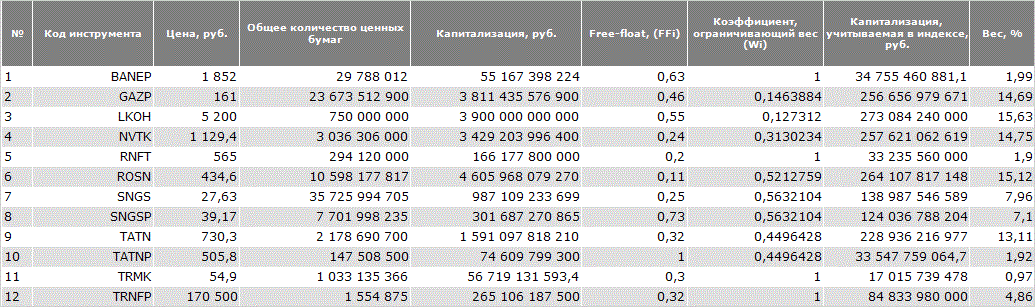

In [5]:
iis=mosex()
t=iis.download_image(r'https://informer.moex.com/ru/index/constituents-MICEXO&G-20190111.gif')  
t

In [6]:
k=iis.industry_indices_list(t)
k

[<PIL.Image.Image image mode=P size=113x20 at 0x19672C0D080>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D160>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D208>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D320>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D390>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D400>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0D470>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0DC18>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0DC88>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0DCF8>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19672C0DD68>,
 <PIL.Image.Image image mode=P size=113x20 at 0x19670BB8BA8>]

In [7]:
kk=k[-3]
kk

In [10]:
kk = kk.convert('RGB') 
open_cv_image = np.array(kk) 
# Convert RGB to BGR 
open_cv_image = open_cv_image[:, :, ::-1].copy() 
open_cv_image

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[204, 213, 204],
        [204, 213, 204],
        [255, 213, 204],
        ...,
        [204, 213, 204],
        [204, 213, 204],
        [255, 255, 255]],

       [[204, 255, 255],
        [255, 213, 204],
        [204, 255, 255],
        ...,
        [204, 255, 204],
        [255, 213, 255],
        [255, 255, 255]],

       ...,

       [[255, 213, 204],
        [204, 213, 204],
        [204, 213, 255],
        ...,
        [204, 213, 255],
        [255, 213, 204],
        [255, 255, 255]],

       [[204, 213, 204],
        [204, 255, 255],
        [255, 213, 204],
        ...,
        [255, 255, 204],
        [204, 213, 255],
        [255, 255, 255]],

       [[255, 213, 204],
        [204, 213, 255],
        [204, 213, 204],
        ...,
        [255, 213, 255],
        [204, 213, 204],
        [255, 255, 255]]

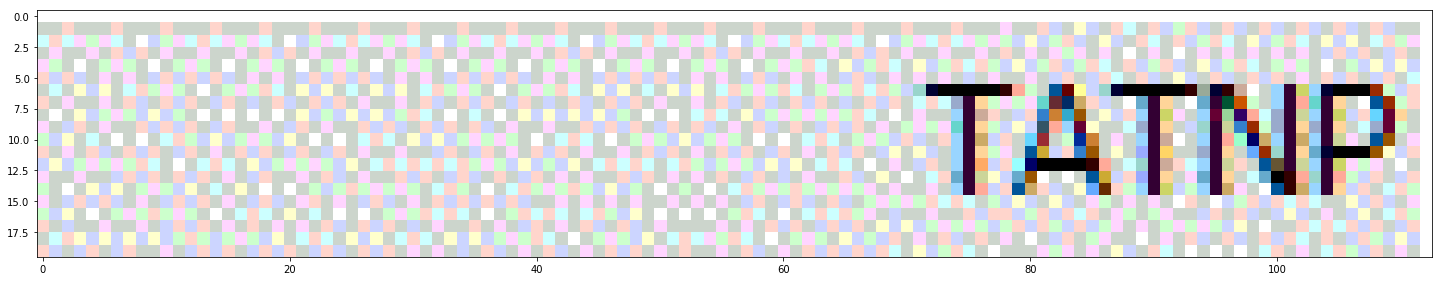

In [11]:
#img = cv2.imread('test.png')
plt.figure(figsize=(25,20))
plt.imshow(open_cv_image)

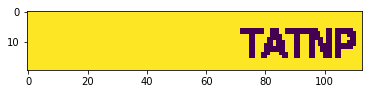

In [24]:

plt.imshow(noise(open_cv_image,True,False,True))

In [26]:
image_to_string(noise(open_cv_image,True,False,False),lang='eng')

'TATNP.'

In [12]:
img_gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

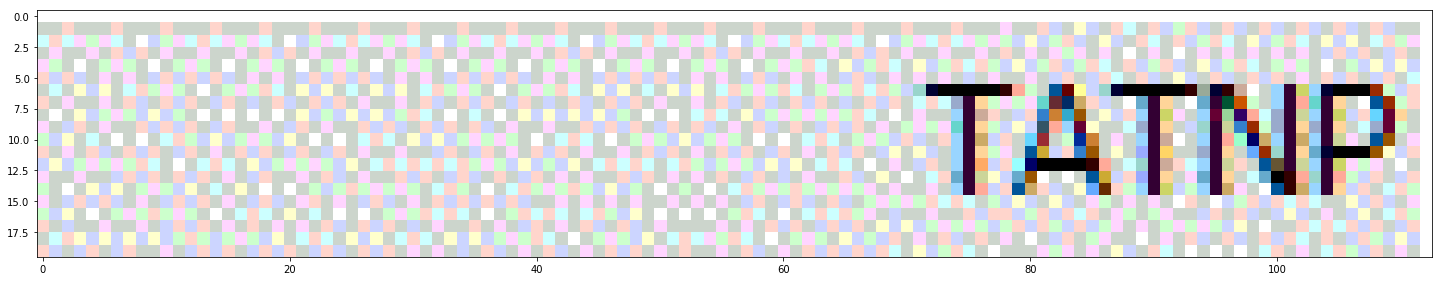

In [16]:
plt.figure(figsize=(25,20))
plt.imshow(open_cv_image)

TATNP


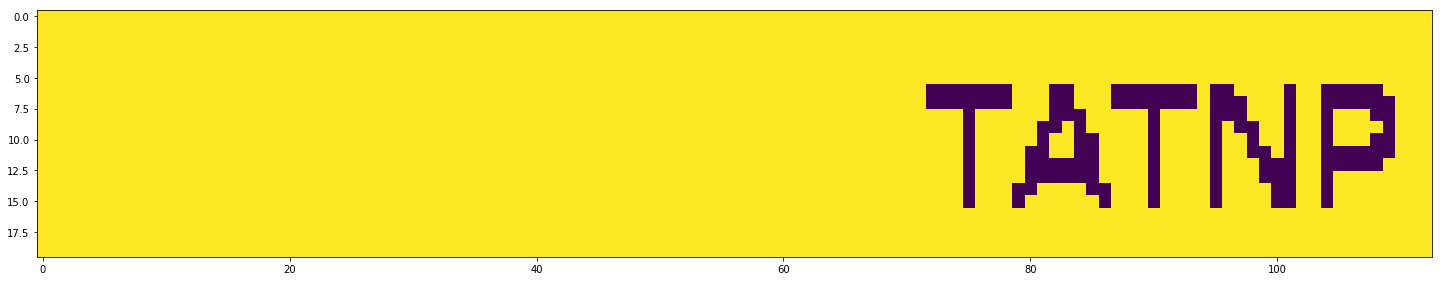

In [44]:
def noise(img,thresh= True,blur= False,dilate = False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if thresh:
        img_gray = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    if blur:
        img_gray = cv2.medianBlur(img_gray, 3)
    
    img_gray = cv2.bitwise_not(img_gray)

    if dilate:
        kernel = np.ones((2, 1), np.uint8)
        img_gray = cv2.morphologyEx(img_gray, cv2.MORPH_DILATE, kernel)
    
    img_gray = cv2.bitwise_not(img_gray)
    return img_gray
converted_img=noise(open_cv_image,True,False,True)
print(image_to_string(converted_img,lang='eng'))

plt.figure(figsize=(25,20))
plt.imshow(converted_img)

True

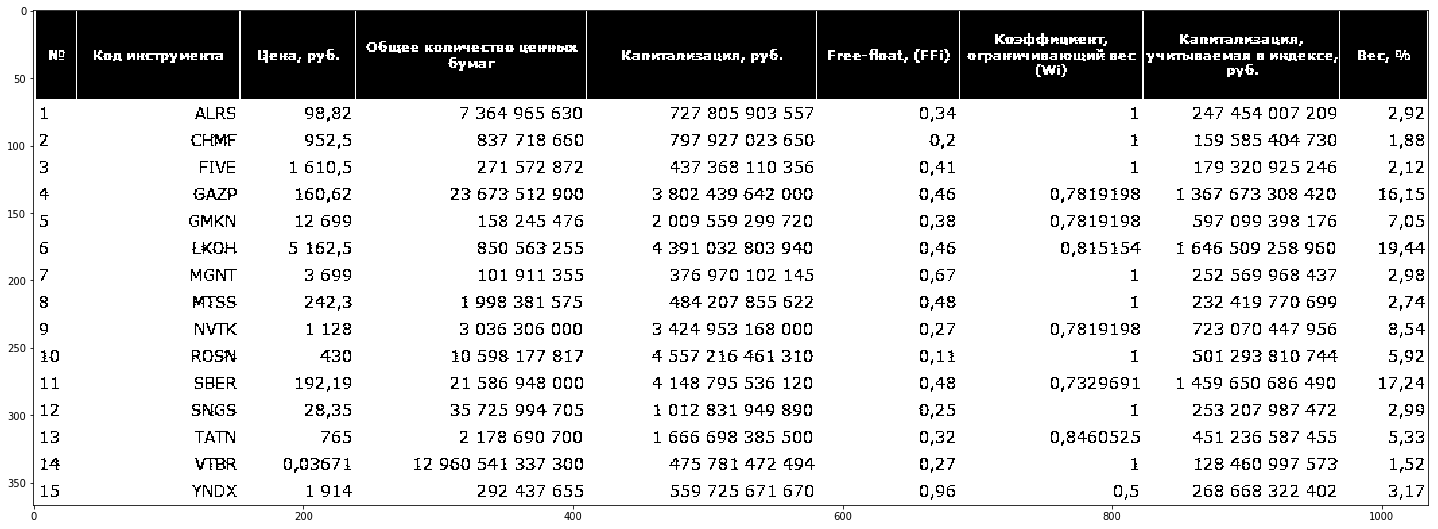

In [244]:
# Tesseract on noisy image
thresh = True
blur = False # Do not use it cause of the thin words
dilate = False

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

if thresh:
    img_gray = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
if blur:
    img_gray = cv2.medianBlur(img_gray, 3)
    
img_gray = cv2.bitwise_not(img_gray)

if dilate:
    kernel = np.ones((2, 2), np.uint8)
    img_gray = cv2.morphologyEx(img_gray, cv2.MORPH_DILATE, kernel)
    
img_gray = cv2.bitwise_not(img_gray)


img = cv2.imread("test_gray.png")
plt.figure(figsize=(25, 20))
plt.imshow(img)
cv2.imwrite('test_gray.png', img_gray)

In [3]:
42/1000

0.042